In [1]:
import numpy as np
from json_tricks import dumps, loads
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import pickle
import socket
from datetime import datetime
import random

import gym
from gym.envs.registration import register, spec
from gym import envs

In [2]:
i = 0
lines = []
with open("data/data4_valid/fl4-comb-new.txt") as f:
    for line in f:
        lines.append(line)

In [3]:
Qs = []
str_combs = []
alls = {}
for i in tqdm(range(len(lines))):
    map_str_comb, dic = lines[i].split("\t")
    obj = loads(dic)
    alls[map_str_comb] = obj['Q']
    Qs.append(obj['Q'])
    str_combs.append(map_str_comb)

100%|██████████| 3828/3828 [00:18<00:00, 210.54it/s]


In [4]:
q_data = np.array([q.flatten() for q in Qs])

In [5]:
X_train, X_test = train_test_split(q_data, test_size=0.10, random_state=42)
X_train_str, X_test_str = train_test_split(str_combs, test_size=0.10, random_state=42)

In [6]:
G_params = pickle.load(open("data/gan/G_params.p", "rb"))
D_params = pickle.load(open("data/gan/D_params.p", "rb"))

In [7]:
Wzh, bzh, Whx, bhx = G_params
Wxh, bxh, Why, bhy = D_params

In [8]:
mb_size = 64
ones_label = Variable(torch.ones(mb_size))

In [9]:
def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

In [52]:
def get_discriminator_score(Q):
    if len(Q.shape) != 1:
        Q = Q.flatten()
    inputs = Variable(torch.from_numpy(Q).float(), requires_grad=True)
    myD = D(inputs)
    return myD.data.numpy()[0][0]

In [11]:
def compute_gradients(Q):
    if len(Q.shape) != 1:
        Q = Q.flatten()
    inputs = Variable(torch.from_numpy(Q).float(), requires_grad=True)
    myD = D(inputs)
    myD.backward(ones_label)
    return inputs.grad.data.numpy()

In [12]:
compute_gradients(np.zeros(64))

array([ 6.6178470e+00,  2.3156791e+00,  1.1006123e+01,  3.8913767e+00,
       -4.8738494e+00, -1.6413541e+02, -1.9151268e+02, -2.1076307e+00,
       -1.2307057e+02, -3.4796887e+02, -2.6039380e+02, -2.7801376e+02,
       -2.3147472e+02, -1.2923804e+02, -1.7280565e+02, -2.3142586e+00,
       -1.6715158e+01,  4.5833797e+00,  9.3884563e+00, -1.1369167e+01,
        8.9289188e-02,  4.8248119e+00,  1.6166460e+01, -9.2224035e+00,
       -5.5585303e+02, -4.4512881e+02, -6.1506409e+02, -4.8284674e+02,
        2.5551620e+01, -2.5080652e+00, -1.1572298e+02, -4.1964989e+00,
        5.6630039e+00,  6.0115285e+00,  8.1801243e+00, -1.3001225e+01,
       -3.9688385e+02, -2.2702179e+01, -4.8363333e+02, -3.8718655e+02,
       -3.6447017e+00,  1.4099720e+01,  8.5110073e+00,  4.6459680e+00,
       -2.5905064e+01, -4.2749836e+01, -4.1083847e+01, -3.7468395e+01,
       -1.1202987e+01, -1.2584569e+02, -1.1334032e+02, -9.2926895e+01,
       -1.3339740e+01, -4.3199222e+02, -2.9518405e+02, -2.7643057e+02,
      

In [13]:
X_test_str[68]

'SHHFFFFFHFHFFFHG'

In [14]:
def new_env(env_map, slippery=True, MY_ENV_NAME='FrozenLakeNonskid-v0'):
    if MY_ENV_NAME in envs.registry.env_specs:
        envs.registry.env_specs.pop(MY_ENV_NAME)

    register(
        id=MY_ENV_NAME,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'is_slippery': slippery, 'desc': env_map},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
    env = gym.make(MY_ENV_NAME)
    return env

In [15]:
def verify(env, Q, num_episodes = 10000):
    print("Running validation...")
    # Set learning parameters
    #create lists to contain total rewards and steps per episode
    #jList = []
    rList = []
    successes = 0
    jTot = 0
    for i in tqdm(range(num_episodes)):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 200:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.argmax(Q[s,:])
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            rAll += r
            s = s1
            if d == True and r > 0:
                jTot += j
                successes += 1
            if d == True:
                break
        rList.append(rAll)
    print("Score over time: " +  str(sum(rList)/num_episodes))
    valid_score = sum(rList)/num_episodes
    try:
        avg_steps = jTot / successes
    except:
        avg_steps = 0
    return valid_score, avg_steps

In [63]:
class Experiment(object):
    def __init__(self, env, num_episodes=10000):
        self.env = env
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.machine = socket.gethostname()
        self.num_episodes = num_episodes
        self.done = False
        self.score = None
        self.start = None
        self.end = None
        self.train_successes = []
        self.valid_score = None
        self.valid_avg_steps = None

    def print_score(self):
        if not self.done:
            print("Run first.")
            return
        print("Score over time: " +  str(self.score))

    def run(self):
        print("Running experiment...")
        if self.done:
            print("Already done running")
            return

        self.start = datetime.now()
        lr = .8
        lr_gan = 0.0001
        e = 0.1
        y = .95
        #create lists to contain total rewards and steps per episode
        jList = []
        rList = []
        for i in tqdm(range(self.num_episodes)):
            #Reset environment and get first new observation
            s = self.env.reset()
            rAll = 0
            d = False
            j = 0
            #The Q-Table learning algorithm
            while j < 200:
                j+=1
                #Choose an action by greedily (with noise) picking from Q table
                a = None
                if random.uniform(0,1) < e:
                    a = self.env.action_space.sample()
                else:
                    a = np.argmax(self.Q[s,:])
                #Get new state and reward from environment
                s1,r,d,_ = self.env.step(a)
                if d == True and r != 1:
                    self.Q[s, a] -= 0.01
                #Update Q-Table with new knowledge
                if i < 100:
                    self.Q[s,a] = self.Q[s,a] + lr*(r + y*np.max(self.Q[s1,:]) - self.Q[s,a])
                else:
                    old_Q = self.Q
                    old_Q[s,a] = self.Q[s,a] + lr*(r + y*np.max(self.Q[s1,:]) - self.Q[s,a])
                    self.Q[s,a] = self.Q[s,a] + get_discriminator_score(old_Q)*(r + y*np.max(self.Q[s1,:]) - self.Q[s,a])
#                     self.Q += lr_gan * compute_gradients(self.Q).reshape((self.env.observation_space.n, self.env.action_space.n))
                rAll += r
                s = s1
                if d == True and r > 0:
                    self.train_successes.append((i, j))
                if d == True:
                    #Reduce chance of random action as we train the model.
        #             e = 1./((i/50) + 10)
                    break
            rList.append(rAll)
        self.done = True
        self.end = datetime.now()
        self.score = sum(rList)/self.num_episodes

    def validate(self):
        valid_score, avg_steps = verify(self.env, self.Q)
        self.valid_score = valid_score
        self.valid_avg_steps = avg_steps

    def dumps(self):
        if not self.done:
            print("Run first.")
            return

        return dumps({'Q': self.Q,
                      'start': self.start,
                      'end': self.end,
                      'train_score': self.score,
                      'num_episodes': self.num_episodes,
                      'train_successes': exp.train_successes,
                      'train_machine' : self.machine,
                      'valid_score' : self.valid_score,
                      'valid_avg_steps' : self.valid_avg_steps
                      })

In [64]:
X_test[68]

array([ 4.62240553e-03,  4.31437450e-03, -2.33870470e-03,  3.74752092e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.91780049e-02,  9.13978974e-02,  5.25127297e-01,  9.80571834e-02,
       -2.16989194e-03,  4.03071899e-03, -2.36852114e-03,  5.07422256e-03,
       -2.30912262e-03,  1.62971750e-03, -1.93540372e-03, -2.42599219e-03,
       -4.77791292e-04, -2.13473235e-03, -2.37695324e-03,  7.28273883e-03,
        4.37929946e-01,  3.86158178e-01,  4.44891241e-01,  4.62239161e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.49928851e-03, -2.49997461e-03, -1.85499096e-03, -2.49837232e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.21015951e-01,  1.65579077e-01,  9.12124093e-01,  1.44932507e-01,
       -1.88222420e-03,  2.35862519e-03, -2.46013756e-03,  6.40087950e-04,
        5.94481094e-03, -

In [65]:
get_discriminator_score(X_test[57])

0.67332566

In [94]:
X_test_str[57]

'SHFHFFFHHFFFFHHG'

In [92]:
line = X_test_str[57]
n = 4
map_str_split = [line[i:i+n] for i in range(0, len(line), n)]
env = new_env(map_str_split)

In [93]:
env.render()
exp = Experiment(env, num_episodes=10000)
exp.run()

  2%|▏         | 191/10000 [00:00<00:10, 945.00it/s] 


SHFH
FFFH
HFFF
FHHG
Running experiment...


100%|██████████| 10000/10000 [00:20<00:00, 480.40it/s]


In [95]:
exp.Q

array([[ 5.04949619e-03,  6.48902020e-02,  1.68409139e-03,
        -1.20491772e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.86584225e-05, -1.44274914e-03, -2.17626578e-03,
        -1.64336998e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.25038836e-04,  8.67442862e-06, -5.67466913e-05,
         2.95894917e-03],
       [ 1.53147373e-03, -1.12053215e-06,  4.49361570e-04,
        -2.24740520e-04],
       [-4.88909580e-04,  8.65362662e-02, -8.60329042e-05,
        -2.28787484e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-7.34219925e-04, -2.10985283e-04, -3.82005394e-05,
        -1.81824085e-03],
       [-5.57266216e-04, -8.97482050e-05, -2.43237558e-04,
         5.57537192e-01],
       [ 1.18679819e-01,  9.95622427e-01,  5.68333696e-03,
      

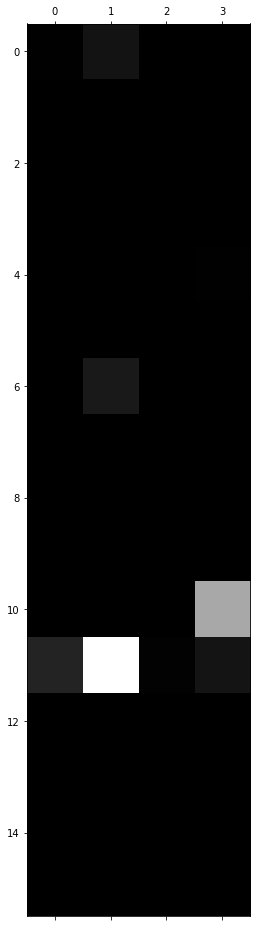

In [96]:
plt.matshow(exp.Q, cmap='Greys_r')

In [97]:
exp.score

0.0332

In [98]:
exp.validate()

 33%|███▎      | 3330/10000 [00:00<00:00, 16639.52it/s]

Running validation...


100%|██████████| 10000/10000 [00:00<00:00, 16813.96it/s]

Score over time: 0.0135
